In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import pickle
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
# load data
train_values = pd.read_csv('data/train_values.csv')
train_label = pd.read_csv('data/train_labels.csv')

In [3]:
# merge the two data frames
df = train_values.merge(train_label, on='id')

In [21]:
# dimensions of dataset
df.shape

(59400, 41)

In [4]:
# preview data
df.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [5]:
# info on dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
# see distribution of numeric features
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [7]:
# get missing values
df.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [8]:
# search for duplicates
df[df['id'].duplicated()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


In [9]:
# get number of unique values for each categorical variable
n_unique = []
for col in df.columns:
    n_unique.append(df[col].nunique())

n_values = pd.DataFrame()
n_values['col'] = df.columns 
n_values['n_unique'] = n_unique
n_values

,col,n_unique
0,id,59400
1,amount_tsh,98
2,date_recorded,356
3,funder,1896
4,gps_height,2428
5,installer,2145
6,longitude,57516
7,latitude,57517
8,wpt_name,37399
9,num_private,65


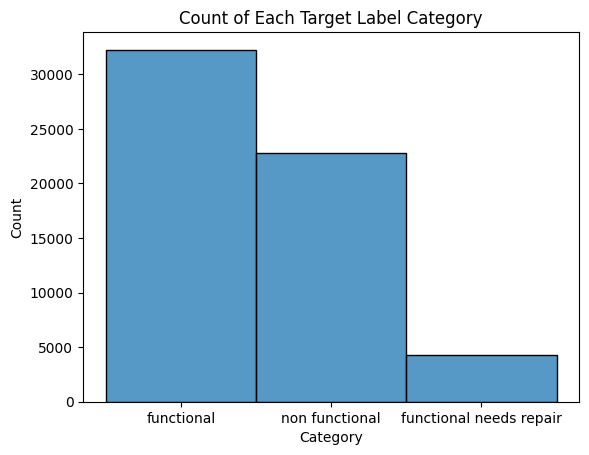

In [20]:
# plot count of each target label
sns.histplot(df['status_group'])
plt.title('Count of Each Target Label Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [ ]:

# subset categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = ['funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region',  'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']

dfs = {}
for col in cat_cols:
    # drop missing values
    subset = df[col].dropna()
    # get unique values in alphabetical order
    unique_vals = pd.Series(subset.unique()).sort_values()
    # create dataframe with unique values and column name
    unique_df = pd.DataFrame({'Unique Values': unique_vals, 'Column Name': col})
    # store dataframe in excel sheet
    dfs[col] = unique_df
